In [ ]:
import numpy as np
from algo_ssa import SSA
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

In [ ]:
def update_array(a, data_tmp):
    i = 0
    while i < len(a) - 2:
        if data_tmp[a[i]] < data_tmp[a[i + 1]] < data_tmp[a[i + 2]]:
            a = np.delete(a, i)
        elif data_tmp[a[i]] > data_tmp[a[i + 1]] > data_tmp[a[i + 2]]:
            a = np.delete(a, i + 2)
        else:
            i += 1
    return a

def get_peaks(data_tmp, distance, duration, sampling_rate):
    data_tmp = data_tmp / np.max(data_tmp)

    t = np.linspace(0, duration, duration * sampling_rate)
    signal = data_tmp

    peak_indices, _ = find_peaks(signal)

    t_peaks = t[peak_indices]
    peak_values = signal[peak_indices]
    interpolation_func = interp1d(t_peaks, peak_values, kind='linear', bounds_error=False, fill_value=0)
    envelope = interpolation_func(t)

    peaks2, _ = find_peaks(envelope, distance=distance)

    peaks2 = update_array(peaks2, data_tmp)
    if len(peaks2) % 2 != 0:
        peaks2 = np.delete(peaks2, len(peaks2) - 1)

    return peaks2

In [ ]:
def delete_unique(a):
    mean = np.mean(a)
    std = np.std(a)
    threshold = 1
    filtered_a = a[np.abs(a - mean) <= threshold * std]

    return filtered_a

def get_mag_0(peaks2, data_tmp):
    mag = data_tmp[peaks2[::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_mag_1(peaks2, data_tmp):
    mag = data_tmp[peaks2[1::2]]
    mean_mag = np.mean(mag)
    std_mag = np.std(mag)
    filtered_mag = mag[np.abs(mag-mean_mag) <= std_mag]
    return np.mean(filtered_mag)

def get_features(data_tmp, peaks2):
    maxm = np.max(data_tmp)
    data_tmp_raw = data_tmp
    data_tmp = data_tmp / maxm

    data_tmp = data_tmp_raw / maxm

    diff_12 = peaks2[1::2] - peaks2[0::2]
    diff_21 = peaks2[2::2] - peaks2[1:-1:2]
    diff_22 = peaks2[2::2] - peaks2[:-2:2]

    diff_12 = delete_unique(diff_12)
    diff_21 = delete_unique(diff_21)
    diff_22 = delete_unique(diff_22)

    m_12 = np.mean(diff_12)
    m_21 = np.mean(diff_21)
    m_22 = np.mean(diff_22)

    mag_1 = get_mag_1(peaks2, data_tmp)
    mag_0 = get_mag_0(peaks2, data_tmp)

    features = np.array([m_12, m_21, m_22, m_12 / m_21, mag_0, mag_1, mag_0 - mag_1, mag_0 / mag_1])

    return features

In [ ]:
def features_indexes(signals, L, trend2period, distance, show ):

    sampling_rate = fs
    idx = []
    features = []

    for i in tqdm(range(len(signals))):
        signal = signals[i]
        if max(signal) > 1:
            continue

        ssa_ = SSA(signal, L)
        # ssa_.calc_wcorr()

        ssa_signal = ssa_.reconstruct(slice(trend2period, L))
        peaks = get_peaks(ssa_signal, distance, duration, sampling_rate)

        if len(peaks) < 16:
            continue

        idx.append(i)
        
        features.append(get_features(ssa_signal, peaks))

    return features, idx

In [ ]:
# def features_indexes(signals, L, trend2period, distance, show ):

#     sampling_rate = fs
#     idx = []
#     features = []

#     for i in tqdm(range(len(signals))):
#         signal = signals[i]
#         if max(signal) > 1:
#             continue

#         ssa_ = SSA(signal, L)
#         # ssa_.calc_wcorr()

#         ssa_signal = ssa_.reconstruct(slice(trend2period, L))
#         peaks = get_peaks(ssa_signal, distance, duration, sampling_rate)

#         if len(peaks) < 16:
#             continue

#         idx.append(i)

#         if show:
#             ssa_.plot_wcorr()
#             # plt.show()

#             plt.subplots(3, 1, figsize=(20, 12))
#             plt.subplot(3, 1, 1)
#             ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
#             ssa_.reconstruct(slice(0, trend2period)).plot(label='Noise Trend')
#             plt.title('Noisy Signal and its Trend')
#             plt.legend()
#             plt.subplot(3, 1, 2)
#             ssa_.orig_TS.plot(alpha=0.3, label='Noisy Signal')
#             ssa_.reconstruct(slice(trend2period, L)).plot(label='Reconstructed Signal')
#             plt.title('Noisy Signal and Reconstructed Signal')
#             plt.legend()
#             plt.subplot(3, 1, 3)
#             plt.plot(signals_clean[i], label='Clean Signal')
#             ssa_.reconstruct(slice(trend2period, L)).plot(label='Reconstructed Signal')
#             plt.plot(ssa_signal)
#             plt.scatter(peaks, ssa_signal[peaks])
#             plt.title('Clean Signal and Reconstructed Signal')
#             plt.legend()

#         features.append(get_features(ssa_signal, peaks))
#     return features, idx

In [ ]:
if __name__ == '__main__':
    duration, fs = 10, 100
    data_train = np.load('../Data/SSA_0.8_RR/train.npy')
    signals_train, S_train, D_train = data_train[:, :1000], data_train[:, -2], data_train[:, -1]
    data_test = np.load('../Data/SSA_0.8_RR/test.npy')
    signals_test, S_test, D_test = data_test[:, :1000], data_test[:, -2], data_test[:, -1]
    
    L = 100
    trend2period = 10
    show = False

    features_train, idx_train = features_indexes(signals_train, L, trend2period, 15, show)
    features_test, idx_test = features_indexes(signals_test, L, trend2period, 10, show)

In [ ]:
features_train_np = np.array(features_train)
features_test_np = np.array(features_test)
idx_train_np = np.array(idx_train)
idx_test_np = np.array(idx_test)

np.save('./features_train_0.8_5000_RR', features_train_np)
np.save('./features_test_0.8_3000_RR', features_test_np)
np.save('./idx_train_0.8_5000_RR', idx_train_np)
np.save('./idx_test_0.8_3000_RR', idx_test_np)

# features_train_np = np.load('features_train_0.8_5000.npy')
# features_test_np = np.load('./features_test_0.8_3000.npy')
# idx_train = np.load('./idx_train_0.8_5000.npy')
# idx_test = np.load('./idx_test_0.8_3000.npy')


In [ ]:
plt.scatter(features_train_np[:, 3].reshape(-1, 1), S_train[idx_train])
plt.scatter(features_test_np[:, 3].reshape(-1, 1), S_test[idx_test])


In [ ]:
from sklearn.linear_model import LinearRegression as LR

reg = LR().fit(features_train_np[:, 3].reshape(-1, 1), S_train[idx_train])
yhat = reg.predict(features_test_np[:, 3].reshape(-1, 1))
np.mean(np.abs(yhat - S_test[idx_test]))

from Tutorial.utils import plot_2vectors
plot_2vectors( S_test[idx_test], yhat, True, 'S_0.8')

In [ ]:
reg = LR().fit(features_train_np[:, -1].reshape(-1, 1), D_train[idx_train])
yhat = reg.predict(features_test_np[:, -1].reshape(-1, 1))
np.mean(np.abs(yhat - D_test[idx_test]))

from Tutorial.utils import plot_2vectors
plot_2vectors( D_test[idx_test], yhat, True, 'D_0.8')

Saved plot to S_0.8.jpg


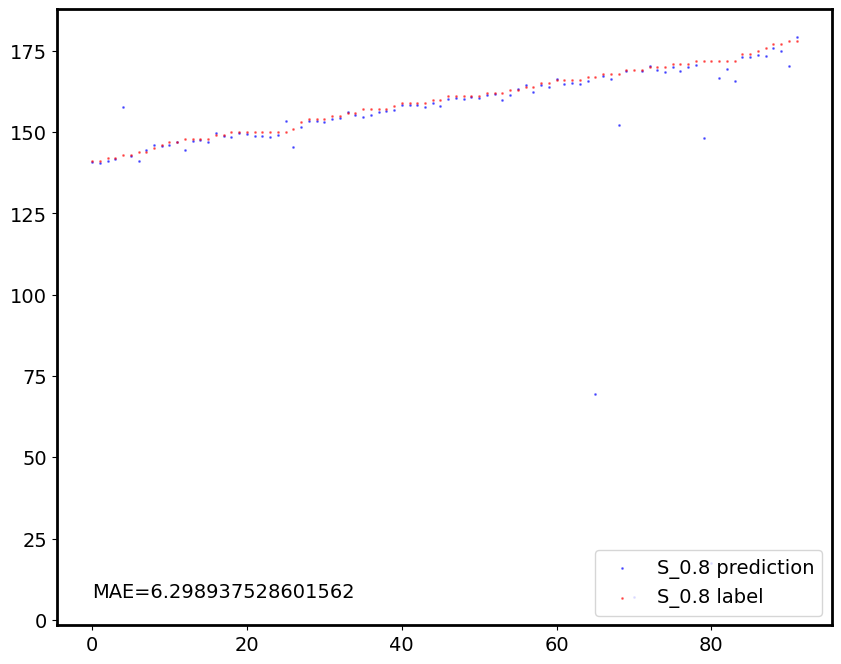

In [37]:
from sklearn.linear_model import LinearRegression as LR

reg = LR().fit(features_train_np[:, 3].reshape(-1, 1), S_train[idx_train])
yhat = reg.predict(features_test_np[:, 3].reshape(-1, 1))
np.mean(np.abs(yhat - S_test[idx_test]))

from Tutorial.utils import plot_2vectors
plot_2vectors( S_test[idx_test], yhat, True, 'S_0.8')

Saved plot to D_0.8.jpg


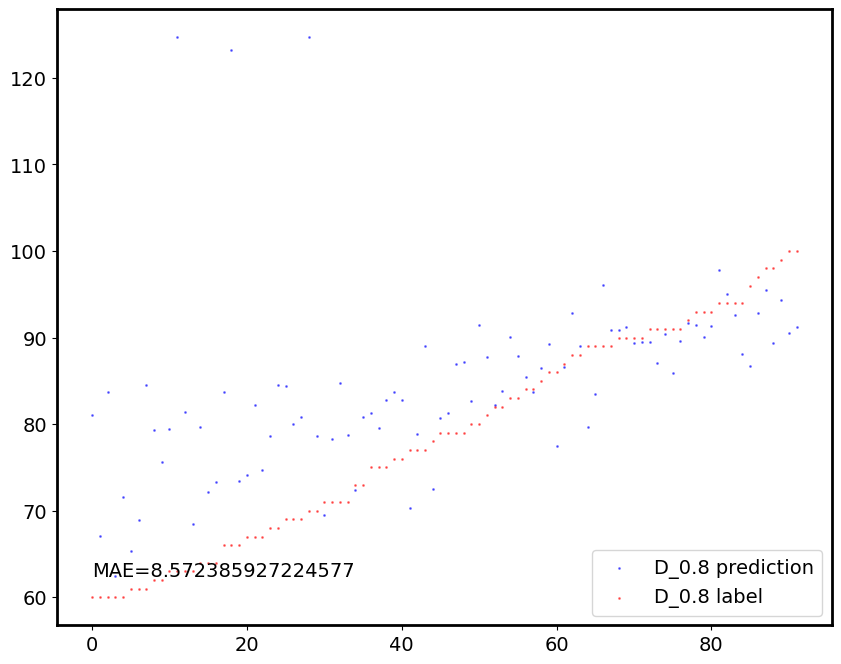

In [38]:
reg = LR().fit(features_train_np[:, -1].reshape(-1, 1), D_train[idx_train])
yhat = reg.predict(features_test_np[:, -1].reshape(-1, 1))
np.mean(np.abs(yhat - D_test[idx_test]))

from Tutorial.utils import plot_2vectors
plot_2vectors( D_test[idx_test], yhat, True, 'D_0.8')